# Build *Bacillus subtilis*

In [1]:
import scipy
scipy.__version__

'0.19.0'

In [2]:
from __future__ import print_function, division, absolute_import

import sys
sys.path.append('/home/jt/UCSD/bacillusme-master')

# python imports
import re
from os.path import join,dirname,abspath
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from bacillusme.util.helper_functions import *

%load_ext autoreload
%autoreload 2
print(cobrame.__file__)
print(bacillusme.__file__)

/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/me_modeling/lib/python3.6/site-packages/cobrame-0.0.9-py3.6.egg/cobrame/__init__.py
/home/jt/me_modeling/lib/python3.6/site-packages/BACILLUSme-0.0.9-py3.6.egg/bacillusme/__init__.py


In [6]:
# Define Models
eco_directory = join(flat_files.ecoli_files_dir, 'iJO1366.json')
ijo_directory = join(flat_files.ecoli_files_dir, 'iYO844_mod.json')
uni_directory = join(flat_files.ecoli_files_dir, 'universal_model.json')

eco = cobra.io.load_json_model(eco_directory)
ijo = cobra.io.load_json_model(ijo_directory)
uni = cobra.io.load_json_model(uni_directory)

In [11]:
## M-model Fixes
ijo.reactions.BIOMASS_BS_10.lower_bound = 0
ijo.reactions.BIOMASS_BS_10.upper_bound = 0

## Part 1: Create minimum solveable ME-model
This will include the bare minimum representations of 
- Transcription Reactions
- Translation Reactions
- Complex Formation Reactions
- Metabolic Reactions

that still produce a working ME-model

### 1) Create Model Object and populate its global info
This includes important parameters that are used to calculate coupling 
constraints as well as organism-specific information such as peptide 
processing types

In [12]:
me = cobrame.MEModel('iJT964-ME')

# ME-models require special OptLang interface if cobrapy version >= 0.6.0
# If cannot import SymbolicParameter, assume using cobrapy
# versions <= 0.5.11
try:
    from optlang.interface import SymbolicParameter
except:
    pass
else:
    me.solver = me_model_interface

# "Translational capacity" of organism
me.global_info['kt'] = 4.5  # (in h-1)scott 2010, RNA-to-protein curve fit
me.global_info['r0'] = 0.087  # scott 2010, RNA-to-protein curve fit
me.global_info['k_deg'] = 1.0/5. * 60.0  # 1/5 1/min 60 min/h # h-1

# Molecular mass of RNA component of ribosome
me.global_info['m_rr'] = 1453. # in kDa

# Average molecular mass of an amino acid
me.global_info['m_aa'] = 109. / 1000.  # in kDa

# Proportion of RNA that is rRNA
me.global_info['f_rRNA'] = .86
me.global_info['m_nt'] = 324. / 1000.  # in kDa
me.global_info['f_mRNA'] = .02

# tRNA associated global information
me.global_info['m_tRNA'] = 25000. / 1000.  # in kDA
me.global_info['f_tRNA'] = .12

# Folding Properties
me.global_info['temperature'] = 37
me.global_info['propensity_scaling'] = .45

# DNA Replication Parameters
me.global_info['GC_fraction'] = 0.507896997096

# Define the types of biomass that will be synthesized in the model
me.add_biomass_constraints_to_model(["protein_biomass", "mRNA_biomass", "tRNA_biomass", "rRNA_biomass",
                                     "ncRNA_biomass", "DNA_biomass", "lipid_biomass", "constituent_biomass",
                                     "prosthetic_group_biomass", "peptidoglycan_biomass"])

# Define ME-model compartments
me.compartments = {"p": "Periplasm", "e": "Extra-organism", "c": "Cytosol", 
                   "im": 'Inner Membrane', 'om': "Outer Membrane", "mc": "ME-model Constraint",
                   "m": "Membrane"}

### 2) Load metabolites and build Metabolic reactions
The below reads in:
- Required 
 * **reaction_matrix.txt** (reaction matrix w/ reactions unlumped, metabolites renamed etc.)
 * **metabolites.txt** (metabolite properties)
 * **reactions.txt** (info on reversiblity, whether enzyme catalyzed etc.)
 * **m_to_me_mets.csv** (mapping of enzymes/complexes used in M-model to their ME-model compatible ID)
 * **protein_complexes.txt** (protein subunit stoichiometry of all complexes, used to identify metabolites as such)
 
It creates a new e coli M-model from this info then incorporates it into the ME-model using *add_m_model_content*. metabolites are added directly reactions are added as StoichiometricData

Metabolite types have different properties in an ME-model so enzyme complexes need added to the model as Complexes not Metabolites. Components in the E. coli M-model that are actually Complexes are compiled in *complex_list*

In [13]:
# m_model = flat_files.get_m_model()
m_model = flat_files.process_m_model(ijo, 'metabolites.txt',
                                     'm_to_me_mets.csv', 'reactions.txt',
                                     'reaction_matrix.txt',
                                     'protein_complexes.txt',
                                     defer_to_rxn_matrix=set())
m_model.reactions.EX_glc__D_e.id = 'EX_glc__D_e'
m_model.repair()
# some of the "metabolites" in iJO1366 "M" model are actually complexes. We pass those in
# so they get created as complexes, not metabolites.
complexes = flat_files.get_complex_subunit_stoichiometry(
    'protein_complexes.txt').keys()
complex_set = set(
    [i.id for i in m_model.metabolites if i.id.split('_mod_')[0] in complexes])
building.add_m_model_content(me, m_model, complex_metabolite_ids=complex_set)

/home/jt/UCSD/bacillusme-master/bacillusme/flat_files.py:60 UserWarning: Complex (BSU34550-MONOMER) in complex_stoichiometry_file twice


BSU15920-MONOMER_mod_pan4p
BSU15920-MONOMER
BSU28500-MONOMER_mod_Oxidized
BSU28500-MONOMER


/home/jt/UCSD/bacillusme-master/bacillusme/corrections.py:28 UserWarning: Creating new metabolite (4fe4s_c)
/home/jt/UCSD/bacillusme-master/bacillusme/corrections.py:28 UserWarning: Creating new metabolite (2fe2s_c)


In [14]:
# This adds exchange reactions for metabolites not contained in iJO1366
# Some of these cannot be produced by the model so they are added here
exchange_list = ['4fe4s_c','2fe2s_c','udcpp_c','pydx5p_c','3fe4s_c','cl_c','sheme_c','cu_c','mn2_c',
                 'bmocogdp_c','dpm_c','thmpp_c','zn2_c','cbl1_c','cobalt2_c']
transport_candidates = {}
bsub_ecoli_blast = pd.read_csv('./building_data/blast_out_bsub_as_ref.txt',sep='\t',index_col=2)
for met_id in exchange_list:   
    # Identify or create metabolites
    if hasattr(me.metabolites,met_id):
        met = me.metabolites.get_by_id(met_id)
    else:
        met = cobrame.Metabolite(met_id)
    met_e_id = re.sub('_.','_e',met_id)
    if hasattr(me.metabolites,met_e_id):
        met_e = me.metabolites.get_by_id(met_e_id)
    else:
        met_e = cobrame.Metabolite(met_e_id)
        
    # Identify or create exchange reaction
    ex_id = 'EX_{}'.format(met_e_id)
    if hasattr(me.reactions,ex_id):
        ex_r = me.reactions.get_by_id(ex_id)
    else:
        ex_r = cobrame.MEReaction(ex_id)
        ex_r.add_metabolites({met_e:-1})
        me.add_reaction(ex_r)
    ex_r.upper_bound = 0 # Avoid secretion of this metabolites. These reactions are
                         # only meant to supply cofactors for which no biosynthetic 
                         # pathway has been defined in the model.
    ex_r.lower_bound = -1000
    
    # Identify or create transport reaction. Available transport reactions in model?
    met_prod_rxns = [rxn.id for rxn in get_reactions_of_met(m_model,met.id,s=1,verbose=0)]
    met_e_cons_rxns = [rxn.id for rxn in get_reactions_of_met(m_model,met_e.id,s=-1,verbose=0)]
    transport = list(set(met_prod_rxns)&set(met_e_cons_rxns))
    ref = 'none'
    if transport:
        ref = 'bsub'
        for r in transport:
            rxn = m_model.reactions.get_by_id(r)
            rxn.lower_bound = 0
            rxn.upper_bound = 1000
            print('Found in model:',met_id,r,rxn.reaction)
    else:
        # In E. coli as template?
        transporters = []
        met_prod_rxns = [rxn.id for rxn in get_reactions_of_met(eco,re.sub('_.','_p',met.id),s=1,verbose=0)]
        met_e_cons_rxns = [rxn.id for rxn in get_reactions_of_met(eco,met_e.id,s=-1,verbose=0)]
        transport = list(set(met_prod_rxns)&set(met_e_cons_rxns))
        if transport:
            ref = 'eco'
            for r in transport:
                rxn = eco.reactions.get_by_id(r)
                transporters = [bsub_ecoli_blast.loc[gene.id]['BSUB_gene'] for gene in rxn.genes \
                                    if gene.id in bsub_ecoli_blast.index]
                if transporters:
                    transport_candidates[met_id] = transporters
                    print('Manually curate: ', met_id, transport)
                else:
                    art = 1
        else:
            art = 1
        if art:
            ## Add artificial reaction
            t_r = cobrame.MEReaction(met_id.split('_')[0].upper()+'t')
            t_r.add_metabolites({met_e:-1,met:1})
            print('Artificially added: ', met_id)
            me.add_reaction(t_r)
    #_ = get_reactions_of_met(me,met_e.id)

Artificially added:  4fe4s_c
Artificially added:  2fe2s_c
Artificially added:  udcpp_c
Artificially added:  pydx5p_c
Artificially added:  3fe4s_c
Manually curate:  cl_c ['CLtex']
Artificially added:  cl_c
Artificially added:  sheme_c
Found in model: cu_c Cut1 atp_c + cu_e + h2o_c --> adp_c + cu_c + h_c + pi_c
Found in model: mn2_c CITt11 cit_e + h_e + mn2_e --> cit_c + h_c + mn2_c
Found in model: mn2_c MNabc atp_c + h2o_c + mn2_e --> adp_c + h_c + mn2_c + pi_c
Found in model: mn2_c MNt2 h_e + mn2_e --> h_c + mn2_c
Artificially added:  bmocogdp_c
Artificially added:  dpm_c
Artificially added:  thmpp_c
Found in model: zn2_c ZNabc atp_c + h2o_c + zn2_e --> adp_c + h_c + pi_c + zn2_c
Found in model: zn2_c CITt15 cit_e + h_e + zn2_e --> cit_c + h_c + zn2_c
Found in model: cbl1_c CBLtex cbl1_e --> cbl1_c
Found in model: cobalt2_c CITt13 cit_e + cobalt2_e + h_e --> cit_c + cobalt2_c + h_c
Found in model: cobalt2_c COBALTt5 cobalt2_e --> cobalt2_c


### 3) Add Transcription and Translation 
The below reads in:
- Required
 * **NC_000913.2.gb** (Genbank sequence annotation)
 * **ecolime/translation.py** (codon to tRNA mapping)
- Optional
 * **TUs_from_ecocyc.txt** (TU definitions, start/stop positions, etc.)
 * **ecolime/translation.py** (dictionary of gene to frameshift mutation)
 
To construct the bare minimimum components of a transcription and translation reactions. For example, transcription reactions at this point include nucleotides and the synthesized RNAs.

In [15]:
element_types = {'CDS', 'rRNA','tRNA', 'ncRNA','misc_RNA'}

In [16]:
gb_filename = join(flat_files.ecoli_files_dir,'NC_000964.gb')                                                                                    
tu_df = flat_files.get_tu_dataframe('TUs_from_bsubcyc.txt')

building.build_reactions_from_genbank(me, gb_filename, tu_df, verbose=False,
                                      frameshift_dict=translation.frameshift_dict,
                                      trna_to_codon=translation.trna_to_codon,
                                      element_types = element_types)



/home/jt/UCSD/cobrame-master/cobrame/util/building.py:320 UserWarning: Processing BSU_misc_RNA_1 as ncRNA
/home/jt/UCSD/cobrame-master/cobrame/util/building.py:320 UserWarning: Processing BSU_misc_RNA_2 as ncRNA
/home/jt/UCSD/cobrame-master/cobrame/util/building.py:320 UserWarning: Processing BSU_misc_RNA_3 as ncRNA
/home/jt/UCSD/cobrame-master/cobrame/util/building.py:320 UserWarning: Processing BSU_misc_RNA_4 as ncRNA
/home/jt/UCSD/cobrame-master/cobrame/util/building.py:320 UserWarning: Processing BSU_misc_RNA_5 as ncRNA
/home/jt/UCSD/cobrame-master/cobrame/util/building.py:320 UserWarning: Processing BSU_misc_RNA_6 as ncRNA
/home/jt/UCSD/cobrame-master/cobrame/util/building.py:320 UserWarning: Processing BSU_misc_RNA_64 as ncRNA
/home/jt/UCSD/cobrame-master/cobrame/util/building.py:320 UserWarning: Processing BSU_misc_RNA_7 as ncRNA
/home/jt/UCSD/cobrame-master/cobrame/util/building.py:320 UserWarning: Processing BSU_misc_RNA_65 as ncRNA
/home/jt/UCSD/cobrame-master/cobrame/util/bu

### 4) Add in complex Formation without modifications (for now)

The below reads in:
- Required
 * **protein_complexes.txt** (Metabolic complexes' protein subunit stoichiometries)
 * **protein_modification.txt** (Type and number of modifications for each protein)

In [17]:
# complex_stoichiometry_dict is a dict of {'complex_id': [{'bnum' : count}]}
rna_components = {'BSU_misc_RNA_2','BSU_misc_RNA_35'} # component id should have 'RNA_ instead' of 'protein_'
# get Metabolic Complex composition from ECOLIme
complex_stoichiometry_dict = flat_files.get_complex_subunit_stoichiometry('protein_complexes.txt', rna_components)
# add complexes to model
complex_modification_dict = flat_files.get_complex_modifications('protein_modification.txt', 'protein_complexes.txt')
building.add_model_complexes(me, complex_stoichiometry_dict, complex_modification_dict, verbose=False)

# remove modifications. they will be added back in later
for data in me.complex_data:
    data.subreactions = {}
# add formation reactions for each of the ComplexDatas
for cplx_data in me.complex_data:
    formation = cplx_data.formation
    if formation:
        formation.update()
    else:
        cplx_data.create_complex_formation()

/home/jt/UCSD/bacillusme-master/bacillusme/flat_files.py:60 UserWarning: Complex (BSU34550-MONOMER) in complex_stoichiometry_file twice


Created <TranslatedGene protein_BSU29679 at 0x7f7a252a99e8> in <ComplexFormation formation_BSU29679-MONOMER at 0x7f7a252a9908>
Created <TranslatedGene protein_G8J2-7 at 0x7f7a24339438> in <ComplexFormation formation_MONOMER8J2-7 at 0x7f7a243395c0>
Created <TranslatedGene protein_G8J2-20 at 0x7f7a26af80f0> in <ComplexFormation formation_MONOMER8J2-49 at 0x7f7a26af84e0>
Created <TranslatedGene protein_G8J2-176 at 0x7f7a24eb6710> in <ComplexFormation formation_MONOMER8J2-60 at 0x7f7a24eb6588>
Created <TranslatedGene protein_G8J2-19 at 0x7f7a2274e0b8> in <ComplexFormation formation_MONOMER8J2-48 at 0x7f7a22748e80>
Created <TranslatedGene protein_G8J2-18 at 0x7f7a2274e208> in <ComplexFormation formation_MONOMER8J2-47 at 0x7f7a2274e278>
Created <TranslatedGene protein_G8J2-16 at 0x7f7a2274e080> in <ComplexFormation formation_MONOMER8J2-46 at 0x7f7a2274e1d0>
Created <TranslatedGene protein_G8J2-13 at 0x7f7a2274e550> in <ComplexFormation formation_MONOMER8J2-45 at 0x7f7a2274e390>
Created <Tran

### 5) Add dummy reaction to model and unmodeled_protein_fraction

Includes the transcription, translation, complex_formation, and metabolic reaction. Sequence based on prevelance of each codon found in *E. coli*.
 - Required
     * [**codon_usage.csv**](http://openwetware.org/wiki/Escherichia_coli/Codon_usage) (codon prevelance)

In [18]:
seq = "ATG"
codons = pandas.read_csv(join(flat_files.ecoli_files_dir, "codon_usage.csv"), index_col=1)
for codon, row in codons.iterrows():
    if row.amino_acid == "Stop":
        continue
    seq += codon * int(row.per_1000 // 3)  # want roughly 300 aa
# get the most used stop codon
seq += codons[codons.amino_acid == "Stop"].sort_values("per_1000").index[-1]
building.add_dummy_reactions(me, seq, update=True)

# dummy proteins can be used to catalyze orphan reactions. This
# ensures that orphan reactions will not becore favored to fulfil 
# unmodeled protein fraction requirement 
rxn = cobrame.SummaryVariable('dummy_protein_to_mass')
me.add_reactions([rxn])
mass = me.metabolites.protein_dummy.formula_weight / 1000.  # in kDa
rxn.add_metabolites({'protein_biomass': -mass, 'protein_dummy': -1,
                     cobrame.Constraint('unmodeled_protein_biomass'): mass})

In [19]:
get_reactions_of_met(me,'unmodeled_protein_biomass')

( dummy_protein_to_mass 0.0 1000.0 ) 	 34.13274694 protein_biomass + protein_dummy --> 34.13274694 unmodeled_protein_biomass


[<SummaryVariable dummy_protein_to_mass at 0x7f7a222509b0>]

In [20]:
for r in me.reactions:
    if 'biomass' in r.id:
        print(r.id, r.reaction , r.bounds)

biomass_dilution biomass -->  (mu, mu)
protein_biomass_to_biomass protein_biomass --> biomass (0.0, 1000.0)
mRNA_biomass_to_biomass mRNA_biomass --> biomass (0.0, 1000.0)
tRNA_biomass_to_biomass tRNA_biomass --> biomass (0.0, 1000.0)
rRNA_biomass_to_biomass rRNA_biomass --> biomass (0.0, 1000.0)
ncRNA_biomass_to_biomass ncRNA_biomass --> biomass (0.0, 1000.0)
DNA_biomass_to_biomass DNA_biomass --> biomass (0.0, 1000.0)
lipid_biomass_to_biomass lipid_biomass --> biomass (0.0, 1000.0)
constituent_biomass_to_biomass constituent_biomass --> biomass (0.0, 1000.0)
prosthetic_group_biomass_to_biomass prosthetic_group_biomass --> biomass (0.0, 1000.0)
peptidoglycan_biomass_to_biomass peptidoglycan_biomass --> biomass (0.0, 1000.0)


In [21]:
for r in me.metabolites.unmodeled_protein_biomass.reactions:
    print(r.id,r.reaction)

dummy_protein_to_mass 34.13274694 protein_biomass + protein_dummy --> 34.13274694 unmodeled_protein_biomass


In [22]:
for r in me.metabolites.protein_dummy.reactions:
    print(r.id,r.reaction)

formation_CPLX_dummy protein_dummy --> CPLX_dummy
translation_dummy 0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_dummy + 24 ala__L_c + 11 arg__L_c + 12 asn__L_c + 17 asp__L_c + 1.37109739368999*(mu + 0.3915)/mu atp_c + 2 cys__L_c + 12 gln__L_c + 23 glu__L_c + 21 gly_c + 7 his__L_c + 24 ile__L_c + 29 leu__L_c + 22 lys__L_c + 1.74892209872384*(mu + 0.3915)/mu mRNA_biomass + 9 met__L_c + 13 phe__L_c + 11 pro__L_c + 18 ser__L_c + 16 thr__L_c + 3 trp__L_c + 11 tyr__L_c + 20 val__L_c --> 1.37109739368999*(mu + 0.3915)/mu adp_c + 1.41146776406036*(mu + 0.3915)/mu amp_c + 1.30979423868313*(mu + 0.3915)/mu cmp_c + 1.08252400548697*(mu + 0.3915)/mu gmp_c + 304.0 - 1.37109739368999*(mu + 0.3915)/mu h2o_c + 1.37109739368999*(mu + 0.3915)/mu h_c + 1.37109739368999*(mu + 0.3915)/mu pi_c + 34.13274694 protein_biomass + protein_dummy + 1.68658436213992*(mu + 0.3915)/mu ump_c
dummy_protein_to_mass 34.13274694 protein_biomass + protein_dummy --> 34.13274694 u

### 6) Assocated Complexes and build Metabolic Reactions 
- Required
    * **enzyme_reaction_association.txt**
    * **reactions.txt** (gives reaction name, reversiblity, source and whether reaction is spontaneous)


In [23]:
# associate reaction id with the old ME complex id (including modifications)
rxn_to_cplx_dict = flat_files.get_reaction_to_complex(m_model)
rxn_info = flat_files.get_reaction_info_frame('reactions.txt')

# Required to add dummy reaction as spontaneous reaction
rxn_info = rxn_info.append(pandas.Series({'description': 'dummy reaction', 'is_reversible': 0,
                                          'is_spontaneous':1}, name='dummy_reaction'))

building.add_reactions_from_stoichiometric_data(me, rxn_to_cplx_dict, rxn_info, update=True)

/home/jt/UCSD/cobrame-master/cobrame/util/building.py:728 UserWarning: Reaction (BIOMASS_BS_10) cannot carry flux


### 7) Incorporate remaining biomass constituents
There are leftover components from the *i*JO1366 biomass equation that either: 
1. have no mechanistic function in the model (glycogen)
2. are cofactors that are regenerated (nad)

Applies demands and coefficients from the *i*JO1366 biomass objective function

In [24]:
me.ngam = 9.
me.gam = 105.053483
me.unmodeled_protein_fraction = .36

biomass_constituents = {
    "10fthf_c": -0.000367,
    "peptido_BS_c": -.101817,
    "psetha_BS_c": -0.00056,
    "mql7_c":-0.000266,
}


rxn = cobrame.SummaryVariable('biomass_constituent_demand')
me.add_reactions([rxn])
rxn.add_metabolites(biomass_constituents)
constituent_mass = sum(me.metabolites.get_by_id(c).formula_weight / 1000. * -v
                     for c, v in biomass_constituents.items())
rxn.lower_bound = mu
rxn.upper_bound = mu
rxn.add_metabolites({me.metabolites.constituent_biomass: constituent_mass})

/home/jt/UCSD/cobrame-master/cobrame/core/model.py:103 UserWarning: Adding ATPM reaction to model
/home/jt/UCSD/cobrame-master/cobrame/core/model.py:86 UserWarning: Adding GAM reaction to model


 #### Lipid components
 Metabolites and coefficients from *i*JO1366 biomass objective function

In [25]:
# Identify lipid metabolites in biomass equation

lipid_demand = {}
for key, value in ijo.reactions.BIOMASS_BS_10.metabolites.items():
    if '_BS_c' in key.id and not key.id in biomass_constituents:
        lipid_demand[key.id] = abs(value)
                
for met, requirement in lipid_demand.items():
    component_mass = me.metabolites.get_by_id(met).formula_weight / 1000.
    rxn = cobrame.SummaryVariable('Demand_' + met)
    me.add_reactions([rxn])
    rxn.add_metabolites({met: -1 * requirement,
                         'lipid_biomass': component_mass * requirement})
    rxn.lower_bound = mu
    rxn.upper_bound = 1000.

# Kdo2lipid4
#requirement = 0.01945  # in mmol/gDW
#met = me.metabolites.get_by_id('kdo2lipid4_e')
#component_mass = met.formula_weight / 1000.
#rxn = cobrame.SummaryVariable('Demand_' + met.id)
#me.add_reactions([rxn])

#rxn.add_metabolites({met.id : -1.*requirement,
#                     'lipid_biomass': component_mass * requirement})
#rxn.lower_bound = mu
#rxn.upper_bound = mu

#### DNA Demand Requirements
Added based on growth rate dependent DNA levels as in [O'brien EJ et al 2013](https://www.ncbi.nlm.nih.gov/pubmed/24084808)

In [26]:
dna_demand_stoich, dna_demand_bound = bacillusme.dna_replication.return_gr_dependent_dna_demand(
    me, me.global_info['GC_fraction'])

dna_replication = cobrame.SummaryVariable("DNA_replication")
me.add_reaction(dna_replication)
dna_replication.add_metabolites(dna_demand_stoich)
dna_biomass = cobrame.Constraint("DNA_biomass")

dna_mw = 0
dna_mw_no_ppi = bacillusme.dna_replication.get_dna_mw_no_ppi_dict(me)
for met, value in me.reactions.DNA_replication.metabolites.items():
    if met.id != 'ppi_c':
        dna_mw -= value * dna_mw_no_ppi[met.id.replace('_c','')] / 1000.
        
dna_replication.add_metabolites({dna_biomass: dna_mw})
dna_replication.lower_bound = dna_demand_bound 
dna_replication.upper_bound = dna_demand_bound 


**Note**: From this point forward, executing every codeblock should result in a solveable ME-model

------

## Part 2: Add metastructures to solving ME-model
This includes:
1. ribosome
2. RNA polymerase
3. charged_tRNAs

Sometimes multiple entities can perform the same role. To prevent a combinatorial explosion of possibilities, we can create  "generic" version, where any of those entities can fill in.

In [27]:
for generic, components in generics.generic_dict.items():
    cobrame.GenericData(generic, me, components).create_reactions()

### 1) Add ribosome
This uses the ribosome composition definition in **ecolime/ribosome.py**

In [28]:
bacillusme.ribosome.add_ribosome(me, verbose=False)

/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (mg2_c) does not have formula


### 2) Add charged tRNA reactions

The tRNA charging reactions were automatically added when loading the genome from the genbank file. However, the charging reactions still need to be made aware of the tRNA synthetases which are responsible.

Uses **trna_charging.py**

In [30]:
aa_synthetase_dict = bacillusme.trna_charging.amino_acid_trna_synthetase
for data in me.tRNA_data:
    data.synthetase = str(aa_synthetase_dict[data.amino_acid])

Generic charged tRNAs are added to translation reactions via SubreactionData below.

All new data added in this block contained in **ecolime/translation.py**

In [31]:
bacillusme.translation.add_charged_trna_subreactions(me)
for data in me.translation_data:
    data.add_initiation_subreactions(start_codons=translation.translation_start_codons,
                                    start_subreactions=set(translation.initiation_subreactions.keys()))

    data.add_elongation_subreactions(elongation_subreactions=set(translation.elongation_subreactions.keys()))

    data.add_termination_subreactions(translation_terminator_dict=translation.translation_stop_dict)

/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:870 UserWarning: initiation subreaction Translation_initiation_factor_InfA not in model
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:870 UserWarning: initiation subreaction Translation_initiation_factor_InfC not in model
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:870 UserWarning: initiation subreaction Translation_gtp_initiation_factor_InfB not in model
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:870 UserWarning: initiation subreaction fmet_addition_at_START not in model
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:836 UserWarning: elongation subreaction Tuf_gtp_regeneration not in model
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:836 UserWarning: elongation subreaction FusA_mono_elongation not in model
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:863 UserWarning: RNA_BSU05343 starts with 'UGC' which is not a start codon
/home/jt/UCSD/cobrame-master/cobra

Adding selenocystein for BSU20040


/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:801 UserWarning: tRNA addition subreaction sec_addition_at_UGA not in model
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:900 UserWarning: No termination enzyme for RNA_BSU20040
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:863 UserWarning: RNA_BSU20060 starts with 'CAA' which is not a start codon
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:900 UserWarning: No termination enzyme for RNA_BSU20060
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:863 UserWarning: RNA_BSU21599 starts with 'AAU' which is not a start codon
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:863 UserWarning: RNA_BSU21670 starts with 'UCU' which is not a start codon
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:900 UserWarning: No termination enzyme for RNA_BSU23330
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:863 UserWarning: RNA_BSU23836 starts with 'UGC' which is not a start codon


### 3) Add Transcription Metacomplexes
#### RNA Polymerase

Data for RNA_polymerase composition fround in **ecolime/transcription**

Uses *tu_df* from **TUs_from_ecocyc.txt**, above

In [32]:
for met in transcription.rna_polymerases:
    rnap_obj = cobrame.RNAP(met)
    me.add_metabolites(rnap_obj)
transcription.add_rna_polymerase_complexes(me, verbose=False)

# associate the correct RNA_polymerase and factors to TUs
sigma_to_rnap_dict = transcription.sigma_factor_complex_to_rna_polymerase_dict
for tu_id in tu_df.index:
    transcription_data = me.process_data.get_by_id(tu_id)
    sigma = tu_df.sigma[tu_id]
    rna_polymerase = sigma_to_rnap_dict[sigma]
    transcription_data.RNA_polymerase = rna_polymerase

#### Degradosome (both for RNA degradation and RNA splicing)

All new data contained in **transcription.py**

In [33]:
me.add_metabolites([cobrame.Complex('RNA_degradosome')])
data = cobrame.ComplexData('RNA_degradosome', me)
for subunit, value in transcription.rna_degradosome.items():
    data.stoichiometry[subunit] = value
data.create_complex_formation(verbose=False)

# Used for RNA splicing
data = cobrame.SubreactionData('RNA_degradation_machine', me)
data.enzyme = 'RNA_degradosome'

data = cobrame.SubreactionData('RNA_degradation_atp_requirement', me)
# .25 water equivaltent for atp hydrolysis per nucleotide
data.stoichiometry = {'atp_c': -.25, 'h2o_c': -.25, 'adp_c': .25,
                      'pi_c': .25, 'h_c': .25}

transcription.add_rna_splicing(me)

------
## Part 3: Add remaining modifications
rRNA modifications handled in *add_ribosome*

### 1) Add complex modifications
*complex_modification_dict* from **protein_modification.text**, above

The rest of the new data contained in **ecolime/modifications.py**

In [34]:
for complex_id, info in complex_modification_dict.items():
    modifications = {}
    for mod, value in info['modifications'].items():
        # stoichiometry of modification determined in 
        # subreaction_data.stoichiometry
        
        modifications['mod_' + mod] = abs(value)
    me.process_data.get_by_id(complex_id).subreactions = modifications

# Adds modification data for more complicated enzyme modifications
# (ie, iron sulfur cluster modification)
bacillusme.modifications.add_modification_procedures(me)

In [35]:
with open("./me_models/iBS_checkpoint.pickle", "wb") as outfile:
    pickle.dump(me, outfile)

In [36]:
with open("./me_models/iBS_checkpoint.pickle", "rb") as outfile:
    me = pickle.load(outfile)

In [37]:
# add formation reactions for each of the ComplexDatas
for cplx_data in me.complex_data:
    formation = cplx_data.formation
    if 'Oxidized' not in cplx_data.id: 
        if formation:
            formation.update()
        else:
            cplx_data.create_complex_formation()

/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (cu_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (mn2_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (zn2_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (cbl1_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (ca2_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (cobalt2_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (ni2_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (fe2_c) does not have formula
/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (pheme_c) does not have formula
/home/jt/UCSD/cobrame-

### 2) Add tRNA mods and asocciate them with tRNA charging reactions
New data from:
1. **ecolime/trna_charging.py** (read via *add_tRNA_modification_procedures()*)
2. **post_transcriptional_modification_of_tRNA.txt** (modification types per tRNA)


In [38]:
# Add tRNA modifications to ME-model
bacillusme.trna_charging.add_trna_modification_procedures(me)

# trna_modifications = {tRNA_id: {modifications: count}}
trna_modifications=flat_files.get_trna_modification_targets()
for trna in trna_modifications:
    for data in me.process_data.query(trna):
        data.subreactions = trna_modifications[trna]

---
## Part 4: Add remaining subreactions
### 1) Add translation related subreactions
All new data from **ecolime/translation.py**

In [39]:
# add the translation subreaction data objects to model
translation.add_translation_subreactions_to_model(me)

# add translation subreaction data to reactions
methionine_cleaved=translation.methionine_cleaved
folding_dict=translation.folding_dict

for data in me.translation_data:
    locus_id = data.id
    if locus_id in methionine_cleaved:
        data.subreactions['N_terminal_methionine_cleavage'] = 1

    for folding_type in folding_dict:
        if locus_id in folding_dict[folding_type]:
            data.subreactions[folding_type] = 1

    # This block was ran above, but should be ran again to 
    # incorporate any subreactions not added previously
    data.add_initiation_subreactions(
        start_codons=translation.translation_start_codons,
        start_subreactions=set(translation.initiation_subreactions.keys()))
    data.add_elongation_subreactions(
        elongation_subreactions=set(translation.elongation_subreactions.keys()))
    data.add_termination_subreactions(
        translation_terminator_dict=translation.translation_stop_dict)

    # add organism specific subreactions associated with peptide processing
    for subrxn in translation.peptide_processing_subreactions:
        data.subreactions[subrxn] = 1

Adding selenocystein for BSU20040


### 2) Add transcription related subreactions
All new data from **ecolime/transcription.py**

In [40]:
for subreaction in transcription.transcription_subreactions:
    subreaction_data = cobrame.SubreactionData(subreaction, me)
    enzymes = transcription.transcription_subreactions[subreaction]['enzymes']
    subreaction_data.stoichiometry = transcription.transcription_subreactions[subreaction]['stoich']
    subreaction_data.enzyme = enzymes

for transcription_data in me.transcription_data:
    # Assume false if not in tu_df
    rho_dependent = tu_df.rho_dependent.get(transcription_data.id, False)
    rho = 'dependent' if rho_dependent else 'independent'
    stable = 'stable' if transcription_data.codes_stable_rna else 'normal'
    transcription_data.subreactions['Transcription_%s_rho_%s' % (stable,
                                                                 rho)] = 1

----
## Part 5: Add in translocation

New data from:
1. **peptide_compartment_and_pathways.txt** (Protein compartment and translocation pathway for each membrane complex)
2. **ecolime/translocation.py** (definitions of each translocation pathway)

In [41]:
# Add TranslocationData
transloc = pandas.read_csv(join(flat_files.ecoli_files_dir,"peptide_compartment_and_pathways.txt"),
                           sep='\t', comment="#")
for pathway, info in bacillusme.translocation.pathway.items():
    if 'alt' not in pathway:
        transloc_data = cobrame.TranslocationData(pathway + '_translocation', me)
    else:
        transloc_data = cobrame.TranslocationData(pathway.replace('_alt', '_translocation_alt'), me)
    transloc_data.enzyme_dict = info['enzymes']
    transloc_data.keff = info['keff']
    transloc_data.length_dependent_energy = info['length_dependent_energy']
    transloc_data.stoichiometry = info['stoichiometry']

# Associate data and add translocation reactions
bacillusme.translocation.add_translocation_pathways(me, transloc, membrane_constraints = False)

# Update stoichiometry of membrane complexes
# new_stoich = {complex_id: protein_w_compartment}
new_stoich = defaultdict(dict)
for cplx, row in transloc.set_index('Complex').iterrows():
    if cplx == 'EG10544-MONOMER':
        continue
    protein = row.Protein.split('(')[0] + '_' + row.Protein_compartment
    value = me.process_data.get_by_id(cplx).stoichiometry['protein_' + row.Protein.split('(')[0]]
    new_stoich[cplx]['protein_' + protein] = float(value)

for cplx, stoich in new_stoich.items():
    complex_data = me.process_data.get_by_id(cplx)
    for met, value in stoich.items():
        complex_data.stoichiometry.pop(met[0:16])
        complex_data.stoichiometry[met] = value
        complex_data.formation.update()
    # Complex ids in protein compartment file doesn't include mods
    # Some have multiple alternative modifications so must loop through these
    for complex_data in me.process_data.query(cplx + '_mod_'):
        for met, value in stoich.items():
            complex_data.stoichiometry.pop(met[0:16])
            complex_data.stoichiometry[met] = value
            complex_data.formation.update()

---
## Part 6: Add Cell Wall Components
All new data from **ecolime/translocation.py**

In [42]:
compartment_dict = {}
for prot, compartment in transloc.set_index('Protein').Protein_compartment.to_dict().items():
    compartment_dict[prot.split('(')[0]] = compartment

#### Add lipid modification SubreactionData

In [43]:
# Bsub m-model doest not have pe and pg metabolites

#### Braun's lipoprotein demand
Metabolites and coefficients as defined in [Liu et al 2014](http://bmcsystbiol.biomedcentral.com/articles/10.1186/s12918-014-0110-6)

#### Correct complex formation IDs if they contain lipoproteins

In [44]:
# Bsub m-model doest not have murein

-----
## Part 7: Set keffs

Either entirely based on SASA or using fit keffs from [Ebrahim et al 2016](https://www.ncbi.nlm.nih.gov/pubmed/27782110?dopt=Abstract)

In [45]:
# # Set keffs to sasa fluxes centered around 65.
# me.set_SASA_keffs(65)

In [46]:
## Get median sasa
from cobrame.core.component import Complex
import numpy as np

sasa_list = []
for met in me.metabolites:
    cplx_sasa = 0.
    if not isinstance(met, Complex):
        continue
    MW = met.formula_weight
    if not MW:
        MW = 0
        print(met.id, ' has no formula')
    cplx_sasa += MW ** (3. / 4)
    sasa_list.append(cplx_sasa)
median_sasa = np.median(np.array(sasa_list))

BSU15920-MONOMER_mod_pan4p  has no formula
BSU28500-MONOMER_mod_Oxidized  has no formula
BSU29679-MONOMER  has no formula
MONOMER8J2-7  has no formula
MONOMER8J2-49  has no formula
MONOMER8J2-60  has no formula
MONOMER8J2-48  has no formula
MONOMER8J2-47  has no formula
MONOMER8J2-46  has no formula
MONOMER8J2-45  has no formula
MONOMER8J2-58  has no formula
MONOMER8J2-59  has no formula
MONOMER8J2-50  has no formula
MONOMER8J2-52  has no formula
MONOMER8J2-55  has no formula
MONOMER8J2-56  has no formula
MONOMER8J2-57  has no formula
BSU23060-MONOMER  has no formula
BSU07540-MONOMER  has no formula


cobra/core/Metabolite.py:97 UserWarning: The element 'X' does not appear in the peridic table


In [47]:
reaction_median_keffs = pandas.read_csv(flat_files.fixpath('reaction_median_keffs.txt'), sep='\t',
                              names=['Reaction', 'Complex', 'Median_Keff'])
keff_list = []
for key, row in reaction_median_keffs.iterrows():
    reaction_id = row['Reaction']
    complex_id = row['Complex']
    median_keff = row['Median_Keff']
    
    real_reaction_id = reaction_id + ''
    
    molecular_weight = me.metabolites.get_by_id(complex_id).formula_weight
    sasa = molecular_weight ** (3./4)
    keff = sasa * median_keff / median_sasa
    
    if keff > 3000:
        keff = 3000.
    elif keff < .01:
        keff = .01
    keff_list.append(keff)
    try:
        me.reactions.get_by_id(reaction_id).keff = keff
        me.reactions.get_by_id(reaction_id).update()
    except:
        continue
    

-----
## Part 8: Model updates and corrections

In [48]:
# Add reaction subsystems from iJO to model
for rxn in ijo.reactions:
    if rxn.id in me.process_data:
        data = me.process_data.get_by_id(rxn.id)
    else:
        continue
    for r in data.parent_reactions:
        r.subsystem = rxn.subsystem

#### Add enzymatic coupling for "carriers"
These are enzyme complexes that act as metabolites in a metabolic reaction (i.e. are metabolites in iJO1366)

In [49]:
for data in me.stoichiometric_data:
    if data.id == 'dummy_reaction':
        continue
        
    for met, value in data.stoichiometry.items():
        if not isinstance(me.metabolites.get_by_id(met), cobrame.Complex) or value > 0:
            continue
            
        subreaction_id = met + '_carrier_activity'
        if subreaction_id not in me.process_data:           
            sub = cobrame.SubreactionData(met + '_carrier_activity', me)
            sub.enzyme = met
        data.subreactions[subreaction_id] = abs(value)

----
## Part 9: Update and save

In [50]:
me.reactions.biomass_dilution.objective_coefficient = 1.
me.reactions.EX_glc__D_e.lower_bound = -1000
me.reactions.EX_o2_e.lower_bound = -1000
me.ngam = 9.
me.gam = 105.053483
me.unmodeled_protein_fraction = .36

me.reactions.BIOMASS_BS_10_FWD_CPLX_dummy.lower_bound = 0
me.reactions.BIOMASS_BS_10_FWD_CPLX_dummy.upper_bound = 0
me.reactions.ATPM_FWD_CPLX_dummy.lower_bound = 0
me.reactions.ATPM_FWD_CPLX_dummy.upper_bound = 0

me.metabolites.get_by_id('mn2_c').formula = 'Mn2'
me.metabolites.get_by_id('mg2_c').formula = 'Mg2'
me.metabolites.get_by_id('ca2_c').formula = 'Ca2'
me.metabolites.get_by_id('cu2_c').formula = 'Cu2'

In [51]:
me.update()

Created <Metabolite Oxidized_c at 0x7f7a252dbd30> in <ComplexFormation formation_BSU33480-MONOMER_mod_Oxidized at 0x7f7a1675b940>


/home/jt/UCSD/cobrame-master/cobrame/core/processdata.py:256 UserWarning: met (Oxidized_c) does not have formula


In [52]:
me.prune()

### Add remaining complex formulas and compartments to model

In [53]:
# Update a second time to incorporate all of the metabolite formulas corectly
for r in me.reactions.query('formation_'):
    r.update()

# Update complex formulas
df = pandas.read_table(join(flat_files.ecoli_files_dir, 'modification.txt'),
                            names=['mod', 'formula','na'])
df = df.drop('na', axis=1).set_index('mod').dropna(how='any')
modification_formulas = df.T.to_dict()
formulas.add_remaining_complex_formulas(me, modification_formulas)

# Update reactions affected by formula update 
for r in me.reactions.query('_mod_lipo'):
    r.update()
for r in me.reactions.query('_mod_glycyl'):
    r.update()
    
# add metabolite compartments
compartments.add_compartments_to_model(me)

### Remaining fields

In [54]:
##
current_gene_ids = [gene.id for gene in me.genes]
for met in me.metabolites:
    met_id = met.id
    if 'protein_BSU' in met_id:
        gene_id = met_id.split('_')[1]
        if gene_id and gene_id not in current_gene_ids:
            try:
                print(gene_id)
                gene = cobra.Gene(gene_id)
                me.genes.append(gene)
            except:
                pass

##
me.reactions.BIOMASS_BS_10_FWD_CPLX_dummy.lower_bound = 0
me.reactions.BIOMASS_BS_10_FWD_CPLX_dummy.upper_bound = 0
me.reactions.ATPM_FWD_CPLX_dummy.lower_bound = 0
me.reactions.ATPM_FWD_CPLX_dummy.upper_bound = 0

## Homogenize exchange reactions
for rxn in me.reactions:
    if 'EX_' in rxn.id:
        try:
            lb = ijo.reactions.get_by_id(rxn.id).lower_bound
            ub = ijo.reactions.get_by_id(rxn.id).upper_bound
            rxn.lower_bound = lb
            rxn.upper_bound = ub
        except:
            print(rxn.id, 'not in m_model')
            
## These exchange reactions need to be opened
mets = ['mn2_e','zn2_e','cobalt2_e']
for met_id in mets:
    r = me.reactions.get_by_id('EX_'+met_id)
    r.lower_bound = -1000
    r.upper_bound = 0

BSU00090
BSU00110
BSU00120
BSU00130
BSU00140
BSU00150
BSU00180
BSU00270
BSU00280
BSU00380
BSU00410
BSU00460
BSU00500
BSU00510
BSU00550
BSU00680
BSU00730
BSU00740
BSU00750
BSU00760
BSU00770
BSU00780
BSU00790
BSU00810
BSU00820
BSU00900
BSU00910
BSU00930
BSU00940
BSU00980
BSU00990
BSU01000
BSU01010
BSU01020
BSU01030
BSU01040
BSU01050
BSU01070
BSU01080
BSU01100
BSU01110
BSU01120
BSU01130
BSU01150
BSU01160
BSU01170
BSU01180
BSU01190
BSU01200
BSU01210
BSU01220
BSU01230
BSU01240
BSU01250
BSU01260
BSU01270
BSU01280
BSU01290
BSU01300
BSU01310
BSU01320
BSU01330
BSU01340
BSU01350
BSU01360
BSU01370
BSU01380
BSU01390
BSU01400
BSU01410
BSU01420
BSU01430
BSU01440
BSU01490
BSU01500
BSU01530
BSU01580
BSU01610
BSU01620
BSU01630
BSU01680
BSU01730
BSU01770
BSU01780
BSU02090
BSU02130
BSU02140
BSU02230
BSU02270
BSU02290
BSU02340
BSU02350
BSU02360
BSU02390
BSU02400
BSU02420
BSU02430
BSU02460
BSU02480
BSU02490
BSU02510
BSU02630
BSU02640
BSU02750
BSU02760
BSU02850
BSU02860
BSU02870
BSU02980
BSU02990
BSU03000
B

## New fixes

In [55]:
# Feb 12, 2020
# Model was synthesizing extra lipids to compensate and reach maximum growth rate.
# Fix: Set lb = ub = mass fraction of lipids
rxns = get_reactions_of_met(me,'lipid_biomass', s=1, verbose=False)
for rxn in rxns:
    rxn.upper_bound = mu
_=get_reactions_of_met(me,'lipid_biomass', s=1, verbose=True)

( Demand_d12dg_BS_c mu mu ) 	 0.00011 d12dg_BS_c --> 0.0097263716968 lipid_biomass
( Demand_lipo4_24_BS_c mu mu ) 	 1.5e-05 lipo4_24_BS_c --> 0.0068361414492 lipid_biomass
( Demand_t12dg_BS_c mu mu ) 	 6.6e-05 t12dg_BS_c --> 0.006905950978080001 lipid_biomass
( Demand_gtca1_45_BS_c mu mu ) 	 0.003624 gtca1_45_BS_c --> 0.026722062249264 lipid_biomass
( Demand_lipo3_24_BS_c mu mu ) 	 1.8e-05 lipo3_24_BS_c --> 0.01205219511504 lipid_biomass
( Demand_m12dg_BS_c mu mu ) 	 8.6e-05 m12dg_BS_c --> 0.00620984507568 lipid_biomass
( Demand_lysylpgly_BS_c mu mu ) 	 2.2e-05 lysylpgly_BS_c --> 0.0018527632855599998 lipid_biomass
( Demand_pgly_BS_c mu mu ) 	 0.000176 pgly_BS_c --> 0.012548534412479996 lipid_biomass
( Demand_lipo2_24_BS_c mu mu ) 	 6e-06 lipo2_24_BS_c --> 0.005660428867679999 lipid_biomass
( Demand_gtca2_45_BS_c mu mu ) 	 0.002347 gtca2_45_BS_c --> 0.026715503385342003 lipid_biomass
( Demand_cdlp_BS_c mu mu ) 	 5e-06 cdlp_BS_c --> 0.0006669379998 lipid_biomass
( Demand_lipo1_24_BS_c m

In [56]:
solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-6)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 129.031870 seconds
Finished substituting S,lb,ub in 3.939861 seconds
Finished makeME_LP in 0.750986 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.25 0.25 1
Finished substituting S,lb,ub in 3.868840 seconds
Finished makeME_LP in 0.740372 seconds
Getting MINOS parameters from ME_NLP...
2 0.0 0.0 0.125 0.125 1
Finished substituting S,lb,ub in 3.860616 seconds
Finished makeME_LP in 0.753149 seconds
Getting MINOS parameters from ME_NLP...
3 0.0625 0.0625 0.125 0.0625 optimal
Finished substituting S,lb,ub in 3.993324 seconds
Finished makeME_LP in 0.749623 seconds
Getting MINOS parameters from ME_NLP...
4 0.09375 0.09375 0.125 0.09375 optimal
Finished substituting S,lb,ub in 3.844184 seconds
Finished makeME_LP in 0.747095 seconds
Getting MINOS parameters from ME_NLP...
5 0.09375 0.09375 0.109375 0.109375 1
Finished substituting S,lb,ub in 3.837456 seconds
Finished makeME_LP in 0.743103 seconds
Gettin

In [57]:
with open("./me_models/solution.pickle", "wb") as outfile:
    pickle.dump(me, outfile)

In [58]:
with open("./me_models/solution.pickle", "rb") as outfile:
    me = pickle.load(outfile)

In [4]:
with open("./me_models/iJL1678b.pickle", "rb") as outfile:
    ecome = pickle.load(outfile)

In [ ]:
# save_json_me_model(me, './me_models/iBS.json')

In [ ]:
for r in me.reactions:
    if 'biomass' in r.id:
        print(r.id,r.reaction)

In [ ]:
import matplotlib.pyplot as plt
type_count = {}
for r in me.reactions:
    rxn_type = str(type(r))
    rxn_type = rxn_type.split('.')[-1].split("'")[0].split('Reaction')[0]
    if rxn_type =='ME':
        rxn_type = 'ExchangeDilution'
    if rxn_type not in type_count.keys():
        type_count[rxn_type] = 0
    type_count[rxn_type] += 1
pd.DataFrame.from_dict({'count':type_count}).plot.bar(legend=False)
plt.ylabel('Count')
plt.title('Reaction breakdown')

In [ ]:
import matplotlib.pyplot as plt
type_count = {}
for r in me.metabolites:
    rxn_type = str(type(r))
    rxn_type = rxn_type.split('.')[-1].split("'")[0]
    if rxn_type not in type_count.keys():
        type_count[rxn_type] = 0
    type_count[rxn_type] += 1
pd.DataFrame.from_dict({'count':type_count}).plot.bar(legend=False)
plt.ylabel('Count')
plt.title('Metabolite breakdown')

In [ ]:
solve_me_model(me, max_mu = 0.5, min_mu = .05, using_soplex=False, precision = 1e-2)

In [ ]:
me.reactions.get_by_id('ASPt2r_FWD_CPLX_dummy').reaction

In [ ]:
#mets = ['cl', 'sheme', 'mg2', 'ni2', 'thmpp', 'cu', 'nad', 'ca2', 'fmn', 'zn2', 'pydx5p', 'pi', 'pheme',
# 'bmocogdp', '4fe4s', 'mn2', 'cbl1', 'cu2', 'k', 'cobalt2', '2fe2s', 'fe2']
mets = ['glc__D']
met_ids = [met+'_c' for met in mets]

In [ ]:
gap_mets = brute_force_check(me,met_ids,'biomass_dilution',0.02)

In [ ]:
me_ = me.copy()

In [ ]:
from qminospy import me2

In [ ]:
# This adds exchange reactions for metabolites not contained in iJO1366
# Some of these cannot be produced by the model so they are added here
exchange_list = ['4fe4s_c','2fe2s_c','udcpp_c','pydx5p_c','3fe4s_c','cl_c','sheme_c','cu_c','mn2_c',
                 'bmocogdp_c','dpm_c','thmpp_c','zn2_c','cbl1_c','cobalt2_c']
transport_candidates = {}
bsub_ecoli_blast = pd.read_csv('./building_data/blast_out_bsub_as_ref.txt',sep='\t',index_col=2)
for met_id in exchange_list:   
    # Identify or create metabolites
    if hasattr(me.metabolites,met_id):
        met = me.metabolites.get_by_id(met_id)
    else:
        met = cobrame.Metabolite(met_id)
    met_e_id = re.sub('_.','_e',met_id)
    if hasattr(me.metabolites,met_e_id):
        met_e = me.metabolites.get_by_id(met_e_id)
    else:
        met_e = cobrame.Metabolite(met_e_id)
        
    # Identify or create exchange reaction
    ex_id = 'EX_{}'.format(met_e_id)
    if hasattr(me.reactions,ex_id):
        ex_r = me.reactions.get_by_id(ex_id)
    else:
        ex_r = cobrame.MEReaction(ex_id)
        ex_r.add_metabolites({met_e:-1})
        me.add_reaction(ex_r)
    ex_r.upper_bound = 0 # Avoid secretion of this metabolites. These reactions are
                         # only meant to supply cofactors for which no biosynthetic 
                         # pathway has been defined in the model.
    ex_r.lower_bound = -1000
    
    # Identify or create transport reaction. Available transport reactions in model?
    met_prod_rxns = [rxn.id for rxn in get_reactions_of_met(m_model,met.id,s=1,verbose=0)]
    met_e_cons_rxns = [rxn.id for rxn in get_reactions_of_met(m_model,met_e.id,s=-1,verbose=0)]
    transport = list(set(met_prod_rxns)&set(met_e_cons_rxns))
    ref = 'none'
    if transport:
        ref = 'bsub'
        for r in transport:
            rxn = m_model.reactions.get_by_id(r)
            rxn.lower_bound = 0
            rxn.upper_bound = 1000
            print('Found in model:',met_id,r,rxn.reaction)
    else:
        # In E. coli as template?
        transporters = []
        met_prod_rxns = [rxn.id for rxn in get_reactions_of_met(eco,re.sub('_.','_p',met.id),s=1,verbose=0)]
        met_e_cons_rxns = [rxn.id for rxn in get_reactions_of_met(eco,met_e.id,s=-1,verbose=0)]
        transport = list(set(met_prod_rxns)&set(met_e_cons_rxns))
        if transport:
            ref = 'eco'
            for r in transport:
                rxn = eco.reactions.get_by_id(r)
                transporters = [bsub_ecoli_blast.loc[gene.id]['BSUB_gene'] for gene in rxn.genes \
                                    if gene.id in bsub_ecoli_blast.index]
                if transporters:
                    transport_candidates[met_id] = transporters
                    print('Manually curate: ', met_id, transport)
                else:
                    art = 1
        else:
            art = 1
        if art:
            ## Add artificial reaction
            t_r = cobrame.MEReaction(met_id.split('_')[0].upper()+'t')
            t_r.add_metabolites({met_e:-1,met:1})
            print('Artificially added: ', met_id)
            me.add_reaction(t_r)
    #_ = get_reactions_of_met(me,met_e.id)

In [ ]:
# This adds exchange reactions for metabolites not contained in iJO1366
# Some of these cannot be produced by the model so they are added here
exchange_list = ['4fe4s_c','2fe2s_c','udcpp_c','mn2_c','pydx5p_c','3fe4s_c','cl_c','sheme_c','cu_c',
                 'bmocogdp_c','dpm_c','thmpp_c','zn2_c','cbl1_c','cobalt2_c']

for met_id in exchange_list:
    r = cobrame.MEReaction("EX_" + met_id)
    me.add_reaction(r)
    r.reaction = met_id + " <=> "

### Breakdown

In [50]:
def get_breakdown(me,field):
    count = {}
    for instance in getattr(me,field):
        instance_type = instance.__class__.__name__
        if instance_type not in count.keys():
            count[instance_type] = 0
        count[instance_type] += 1
    return pd.DataFrame.from_dict({'count':count})

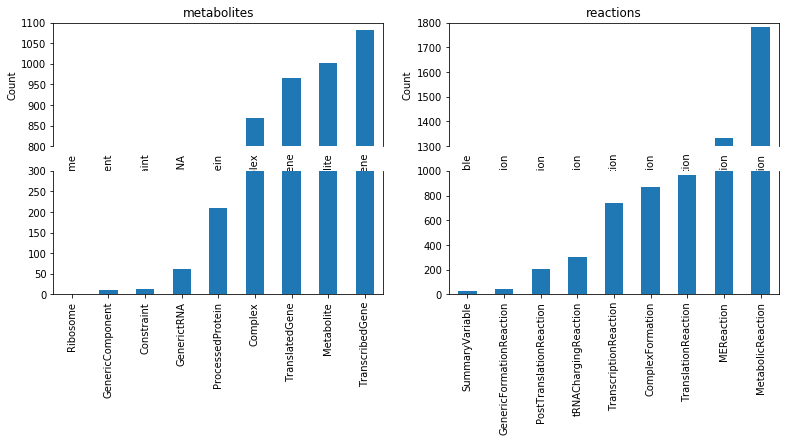

In [71]:
import matplotlib.pyplot as plt
fields = ['metabolites','reactions']

lims = np.array([[0,300,800,1100],[0,1000,1300,1800]])

fig,ax = plt.subplots(2,len(fields),sharex=False)
plt.rcParams['svg.fonttype'] = 'none'
for idx,f in enumerate(fields):
    df = get_breakdown(me,f).sort_values(by='count')
    
    df.plot.bar(legend=False,figsize=(13,5),ax=ax[0,idx])
    df.plot.bar(legend=False,figsize=(13,5),ax=ax[1,idx])
    
    ax[0,idx].set_ylim(lims[idx,2], lims[idx,3])  # outliers only
    ax[1,idx].set_ylim(lims[idx,0], lims[idx,1])  # most of the data
    
    ax[0,idx].spines['bottom'].set_visible(False)
    ax[1,idx].spines['top'].set_visible(False)
    ax[0,idx].tick_params(axis='x', which='both',bottom=False)
    
    ax[0,idx].tick_params(labeltop=False)  # don't put tick labels at the top
    ax[1,idx].xaxis.tick_bottom()
    
    
    ax[0,idx].set_ylabel('Count')
    ax[0,idx].set_title(f)
fig.savefig("./analysis/figures/feature_breakdown.svg", format="SVG")

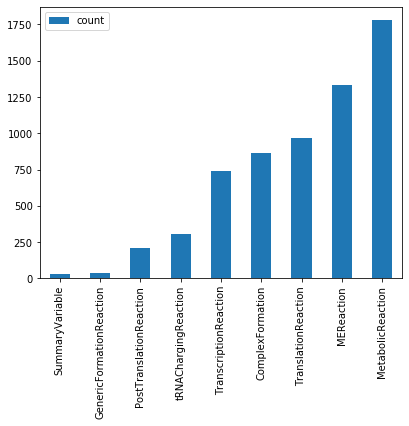

In [80]:
df = get_breakdown(me,fields[1])
df.sort_values(by='count').plot.bar(figsize=(6.5,5))
plt.savefig("./analysis/figures/reaction_breakdown.svg", format="SVG")

In [53]:
a=0
for r in me.reactions:
    instance_type = r.__class__.__name__
    if instance_type=='MEReaction' and 'DM_RNA' in r.id:
        a += 1
print(a)

1082


In [67]:
temp = get_gene_annotation(me,m_model)

100%|██████████| 4211/4211 [00:14<00:00, 287.27it/s] 


In [81]:
i=0
for m in me.metabolites:
    if isinstance(m,cobrame.TranslatedGene):
        i+=1
print(i)

965


In [55]:
df = get_breakdown(me,fields[0])
df.div(df.sum())

,count
Complex,0.206127
Constraint,0.002850
GenericComponent,0.002612
GenerictRNA,0.014723
Metabolite,0.237711
ProcessedProtein,0.049632
Ribosome,0.000237
TranscribedGene,0.256946
TranslatedGene,0.229162


In [56]:
get_reactions_of_met(me,'etoh_c')

( ALCD2y_FWD_BSU26970-MONOMER 0 999999.0 ) 	 4.27350427350427e-6*mu BSU26970-MONOMER + etoh_c + nadp_c <=> acald_c + h_c + nadph_c
( ALCD2y_REV_BSU27010-MONOMER 0 999999.0 ) 	 2.97433526877463e-6*mu BSU27010-MONOMER + acald_c + h_c + nadph_c <=> etoh_c + nadp_c
( ALCD2y_FWD_BSU27010-MONOMER 0 999999.0 ) 	 2.97433526877463e-6*mu BSU27010-MONOMER + etoh_c + nadp_c <=> acald_c + h_c + nadph_c
( ALCD2y_REV_CPLX8J2-194 0 999999.0 ) 	 4.27350427350427e-6*mu CPLX8J2-194 + acald_c + h_c + nadph_c <=> etoh_c + nadp_c
( ALCD2y_FWD_CPLX8J2-194 0 999999.0 ) 	 4.27350427350427e-6*mu CPLX8J2-194 + etoh_c + nadp_c <=> acald_c + h_c + nadph_c
( ETOHtex_FWD_SPONT 0 1000.0 ) 	 etoh_e <=> etoh_c
( ALCD2y_REV_BSU26970-MONOMER 0 999999.0 ) 	 4.27350427350427e-6*mu BSU26970-MONOMER + acald_c + h_c + nadph_c <=> etoh_c + nadp_c


[<MetabolicReaction ALCD2y_FWD_BSU26970-MONOMER at 0x7f32c5b6d400>,
 <MetabolicReaction ALCD2y_REV_BSU27010-MONOMER at 0x7f32c5b6d710>,
 <MetabolicReaction ALCD2y_FWD_BSU27010-MONOMER at 0x7f32c5b6d940>,
 <MetabolicReaction ALCD2y_REV_CPLX8J2-194 at 0x7f32c5b6d5f8>,
 <MetabolicReaction ALCD2y_FWD_CPLX8J2-194 at 0x7f32c5b6d7b8>,
 <MetabolicReaction ETOHtex_FWD_SPONT at 0x7f32c50702e8>,
 <MetabolicReaction ALCD2y_REV_BSU26970-MONOMER at 0x7f32c5b6d0f0>]

In [57]:
for m in me.metabolites:
    if 'ba' in m.name:
        print(m.id, m.name)

cbasp_c N-Carbamoyl-L-aspartate
cbp_c Carbamoyl phosphate


In [58]:
len(me.reactions)-len(m_model.reactions)

5028

In [59]:
m_model.reactions.BIOMASS_BS_10.reaction

'0.000367 10fthf_c + 0.266902 ala__L_c + 0.00467 amp_c + 0.193021 arg__L_c + 0.147987 asn__L_c + 0.148014 asp__L_c + 105.053483 atp_c + 0.003205 ca2_c + 5e-06 cdlp_BS_c + 0.000251 cdp_c + 0.001042 cmp_c + 0.038902 ctp_c + 0.05699 cys__L_c + 0.00011 d12dg_BS_c + 0.022982 datp_c + 0.01738 dctp_c + 0.017398 dgtp_c + 0.022899 dttp_c + 0.00345 fe3_c + 0.00018 gdp_c + 0.260335 gln__L_c + 0.260378 glu__L_c + 0.408288 gly_c + 0.000503 gmp_c + 0.003624 gtca1_45_BS_c + 0.002347 gtca2_45_BS_c + 0.001819 gtca3_45_BS_c + 0.062667 gtp_c + 105.0 h2o_c + 0.081739 his__L_c + 0.269905 ile__L_c + 0.706312 k_c + 0.346445 leu__L_c + 7e-06 lipo1_24_BS_c + 6e-06 lipo2_24_BS_c + 1.8e-05 lipo3_24_BS_c + 1.5e-05 lipo4_24_BS_c + 0.323093 lys__L_c + 2.2e-05 lysylpgly_BS_c + 8.6e-05 m12dg_BS_c + 0.113326 met__L_c + 0.101714 mg2_c + 0.000266 mql7_c + 0.016164 nad_c + 0.000934 nadp_c + 0.000216 nadph_c + 0.101817 peptido_BS_c + 0.000176 pgly_BS_c + 0.175939 phe__L_c + 0.000918 ppi_c + 0.160642 pro__L_c + 0.00056 pse

In [60]:
get_reactions_of_met(me,'lipid_biomass')

( Demand_gtca3_45_BS_c mu mu ) 	 0.001819 gtca3_45_BS_c <=> 0.026717435194354 lipid_biomass
( Demand_lipo3_24_BS_c mu mu ) 	 1.8e-05 lipo3_24_BS_c <=> 0.01205219511504 lipid_biomass
( Demand_tcam_BS_c mu mu ) 	 0.003112 tcam_BS_c <=> 0.04316222890296 lipid_biomass
( Demand_lipo1_24_BS_c mu mu ) 	 7e-06 lipo1_24_BS_c <=> 0.00591416142296 lipid_biomass
( Demand_gtca1_45_BS_c mu mu ) 	 0.003624 gtca1_45_BS_c <=> 0.026722062249264 lipid_biomass
( Demand_lysylpgly_BS_c mu mu ) 	 2.2e-05 lysylpgly_BS_c <=> 0.0018527632855599998 lipid_biomass
( Demand_cdlp_BS_c mu mu ) 	 5e-06 cdlp_BS_c <=> 0.0006669379998 lipid_biomass
( Demand_lipo4_24_BS_c mu mu ) 	 1.5e-05 lipo4_24_BS_c <=> 0.0068361414492 lipid_biomass
( Demand_gtca2_45_BS_c mu mu ) 	 0.002347 gtca2_45_BS_c <=> 0.026715503385342003 lipid_biomass
( Demand_lipo2_24_BS_c mu mu ) 	 6e-06 lipo2_24_BS_c <=> 0.005660428867679999 lipid_biomass
( Demand_d12dg_BS_c mu mu ) 	 0.00011 d12dg_BS_c <=> 0.0097263716968 lipid_biomass
( Demand_t12dg_BS_c 

[<SummaryVariable Demand_gtca3_45_BS_c at 0x7f32c507da20>,
 <SummaryVariable Demand_lipo3_24_BS_c at 0x7f32c507d860>,
 <SummaryVariable Demand_tcam_BS_c at 0x7f32c507de80>,
 <SummaryVariable Demand_lipo1_24_BS_c at 0x7f32c507d6a0>,
 <SummaryVariable Demand_gtca1_45_BS_c at 0x7f32c507dcc0>,
 <SummaryVariable Demand_lysylpgly_BS_c at 0x7f32c507d4e0>,
 <SummaryVariable Demand_cdlp_BS_c at 0x7f32c507db00>,
 <SummaryVariable Demand_lipo4_24_BS_c at 0x7f32c507d940>,
 <SummaryVariable Demand_gtca2_45_BS_c at 0x7f32c507df60>,
 <SummaryVariable Demand_lipo2_24_BS_c at 0x7f32c507d780>,
 <SummaryVariable Demand_d12dg_BS_c at 0x7f32c507dda0>,
 <SummaryVariable Demand_t12dg_BS_c at 0x7f32c507d5c0>,
 <SummaryVariable Demand_m12dg_BS_c at 0x7f32c5070fd0>,
 <SummaryVariable Demand_pgly_BS_c at 0x7f32c507dbe0>,
 <SummaryVariable lipid_biomass_to_biomass at 0x7f32ca2a67f0>]

In [61]:
for m in me.metabolites:
    if 'flavin' in m.name:
        print(m.id, m.name)

ribflvRD_c Reduced riboflavin C17H22N4O6
ribflv_c Riboflavin C17H20N4O6
ribflv_e Riboflavin C17H20N4O6


In [82]:
get_reactions_of_met(me,'BSU03040-MONOMER')

( formation_BSU03040-MONOMER 0.0 1000.0 ) 	 protein_BSU03040_Inner_Membrane --> BSU03040-MONOMER
( AAMYL_1_FWD_BSU03040-MONOMER 0 999999.0 ) 	 1.82732695506128e-6*mu BSU03040-MONOMER + starch_e <=> dextrin_e


[<ComplexFormation formation_BSU03040-MONOMER at 0x7f32c658fb38>,
 <MetabolicReaction AAMYL_1_FWD_BSU03040-MONOMER at 0x7f32c5daddd8>]

In [103]:
# Define Models
temp = join(flat_files.ecoli_files_dir, 'iYO844.json')
clean_bsub = cobra.io.load_json_model(temp)

In [105]:
clean_bsub.optimize()

<Solution 0.12 at 0x7f32c6646cc0>

In [136]:
me_dict = me.get_metabolic_flux()
m_dict = clean_bsub.solution.x_dict

comparison_dict = {}
for r in me_dict:
    if r not in m_dict:
        print('Skipping {}'.format(r))
        continue
    comparison_dict[r] = {}
    comparison_dict[r]['m'] = m_dict[r]
    comparison_dict[r]['me'] = me_dict[r]

Skipping CU2abc1
Skipping COBALTt5
Skipping ETOHtex
Skipping CBLtex
Skipping dummy_reaction
Skipping EX_cbl1_e
Skipping EX_4fe4s_e
Skipping EX_2fe2s_e
Skipping EX_udcpp_e
Skipping EX_pydx5p_e
Skipping EX_3fe4s_e
Skipping EX_cl_e
Skipping EX_sheme_e
Skipping EX_cu_e
Skipping EX_bmocogdp_e
Skipping EX_dpm_e
Skipping EX_thmpp_e
Skipping DM_RNA_BSU23050
Skipping DM_RNA_BSU29190
Skipping DM_RNA_BSU29180
Skipping DM_RNA_BSU39670
Skipping DM_RNA_BSU39720
Skipping DM_RNA_BSU39700
Skipping DM_RNA_BSU39760
Skipping DM_RNA_BSU39710
Skipping DM_RNA_BSU39730
Skipping DM_RNA_BSU39740
Skipping DM_RNA_BSU39750
Skipping DM_RNA_BSU24310
Skipping DM_RNA_BSU03930
Skipping DM_RNA_BSU10270
Skipping DM_RNA_BSU12910
Skipping DM_RNA_BSU35660
Skipping DM_RNA_BSU04340
Skipping DM_RNA_BSU25200
Skipping DM_RNA_BSU40330
Skipping DM_RNA_BSU40340
Skipping DM_RNA_BSU40320
Skipping DM_RNA_BSU35620
Skipping DM_RNA_BSU26390
Skipping DM_RNA_BSU25760
Skipping DM_RNA_BSU28850
Skipping DM_RNA_BSU28870
Skipping DM_RNA_BSU2886

In [156]:
df = pd.DataFrame.from_dict(comparison_dict).T

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:1 RuntimeWarning: invalid value encountered in log10


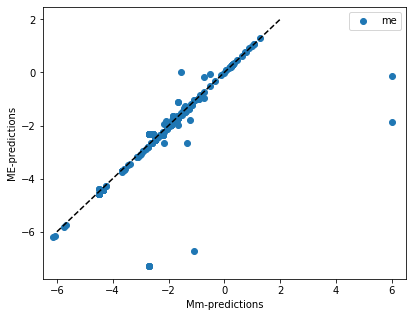

In [215]:
np.log10(df[df.abs()>0]).plot(x='m',y='me',style='o',figsize=(6.5,5))
plt.plot([-6,2],[-6,2],'--k')

plt.xlim([-6.5,6.5])
plt.ylabel('ME-predictions')
plt.xlabel('Mm-predictions')
plt.savefig('analysis/figures/me_m_flux_XY.svg',format='SVG')

/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:2 RuntimeWarning: invalid value encountered in log10
/home/jt/UCSD/ME_modelling/ME_env/lib/python3.6/site-packages/ipykernel_launcher.py:3 RuntimeWarning: invalid value encountered in log10


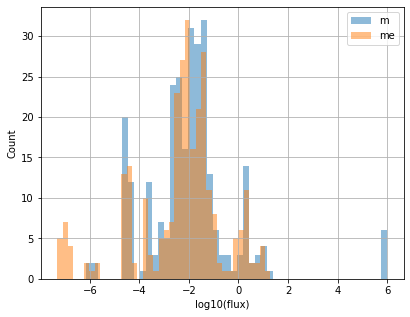

In [205]:
fig = plt.figure(figsize=(6.5,5))
np.log10(df[df.abs()>0])['m'].hist(bins=50,alpha=0.5,label='m')
np.log10(df[df.abs()>0])['me'].hist(bins=40,alpha=0.5,label='me')

plt.xlabel('log10(flux)')
plt.ylabel('Count')
plt.legend()
plt.savefig('analysis/figures/me_m_flux_distributions.svg',format='SVG')

In [223]:
get_reactions_of_met(me,'fol_c',only_types=['MetabolicReaction'])

[]

In [224]:
me.reactions.translation_BSU00090.reaction

'10fthf_c + 0.00208119658119658*mu BSU01120-MONOMER + 4.27350427350427e-6*mu BSU01390-MONOMER + 4.27350427350427e-6*mu BSU15720-MONOMER + 4.27350427350427e-6*mu BSU15730-MONOMER + 0.00208119658119658*mu BSU16500-MONOMER + 4.27350427350427e-6*mu BSU16520-MONOMER + 8.54700854700855e-6*mu BSU16630-MONOMER + 4.27350427350427e-6*mu BSU28870-MONOMER + 4.27350427350427e-6*mu BSU35290-MONOMER + 0.000498399634202103*mu + 0.000195123456790123 + 0.00598079561042524*(mu + 0.3915)/mu RNA_BSU00090 + 2.55589556001079e-8*mu + 1.00063311174422e-8 RNA_degradosome + 36 ala__L_c + 23 arg__L_c + 14 asn__L_c + 27 asp__L_c + 487.0 + 2.19196159122085*(mu + 0.3915)/mu atp_c + 3 cys__L_c + 4.27350427350427e-6*mu generic_RF + 0.00208119658119658*mu generic_Tuf + 29.0 generic_tRNA_AAA_lys__L_c + 8.0 generic_tRNA_AAC_asn__L_c + 8.0 generic_tRNA_AAG_lys__L_c + 6.0 generic_tRNA_AAU_asn__L_c + 18.0 generic_tRNA_ACA_thr__L_c + generic_tRNA_ACC_thr__L_c + 4.0 generic_tRNA_ACG_thr__L_c + 12.0 generic_tRNA_ACU_thr__L_c +

In [226]:
me.reactions.transcription_TU_BSU_rRNA_10.reaction

'4.27350427350427e-6*mu BSU00550-MONOMER + 4.27350427350427e-6*mu BSU01010-MONOMER + 4.27350427350427e-6*mu BSU16600-MONOMER + 4.27350427350427e-6*mu BSU27320-MONOMER + 4.27350427350427e-6*mu CPLX8J2-30 + 571 atp_c + 920 ctp_c + 658 gtp_c + 779 utp_c --> RNA_BSU_rRNA_10 + 2928 ppi_c + 931.440514868 rRNA_biomass'

In [4]:
get_reactions_of_met(me,'generic_tRNA_UGU_cys__L_c',s=1)

( charging_tRNA_BSU_tRNA_42_UGU 0.0 1000.0 ) 	 4.27350427350427e-6*mu*(0.000116266666666667*mu + 1.0000455184) BSU00940-MONOMER + 0.000116266666666667*mu + 4.55184e-5 RNA_BSU_tRNA_42 + 0.000116266666666667*mu + 4.55184e-5 cys__L_c --> generic_tRNA_UGU_cys__L_c


[<tRNAChargingReaction charging_tRNA_BSU_tRNA_42_UGU at 0x7f86eda60208>]

In [7]:
ecome.reactions.charging_tRNA_b0202_AUC.reaction

' --> 0.000116266666666667*mu + 4.55184e-5 5mta_c + -4.27350427350427e-6*mu*(0.000116266666666667*mu + 1.0000455184) IleS_mono_mod_2:zn2 + -0.000116266666666667*mu - 4.55184e-5 RNA_b0202 + -4.27350427350427e-6*mu*(0.000116266666666667*mu + 4.55184e-5) TrmA_mono + -4.27350427350427e-6*mu*(0.000116266666666667*mu + 4.55184e-5) TruB_mono + -4.27350427350427e-6*mu*(0.000116266666666667*mu + 4.55184e-5) YggH_mono + -4.27350427350427e-6*mu*(0.000116266666666667*mu + 4.55184e-5) YqcB_mono + -4.27350427350427e-6*mu*(0.000116266666666667*mu + 4.55184e-5) YrdC_mono + 0.000232533333333333*mu + 9.10368e-5 ahcys_c + -0.0003488*mu - 0.0001365552 amet_c + 0.000116266666666667*mu + 4.55184e-5 amp_c + -0.000116266666666667*mu - 4.55184e-5 atp_c + -8.54700854700855e-6*mu*(0.000116266666666667*mu + 4.55184e-5) generic_Dus + generic_tRNA_AUC_ile__L_c + 0.000116266666666667*mu + 4.55184e-5 h2o_c + 0.000232533333333333*mu + 9.10368e-5 h_c + -0.000116266666666667*mu - 4.55184e-5 hco3_c + -0.00011626666666666

In [8]:
ecome.reactions.translation_b0002.reaction

'10fthf_c + 91 ala__L_c + 46 arg__L_c + 38 asn__L_c + 44 asp__L_c + 12 cys__L_c + 22.0 generic_tRNA_AAA_lys__L_c + 16.0 generic_tRNA_AAC_asn__L_c + 12.0 generic_tRNA_AAG_lys__L_c + 22.0 generic_tRNA_AAU_asn__L_c + 2.0 generic_tRNA_ACA_thr__L_c + 19.0 generic_tRNA_ACC_thr__L_c + 8.0 generic_tRNA_ACG_thr__L_c + 5.0 generic_tRNA_ACU_thr__L_c + 12.0 generic_tRNA_AGC_ser__L_c + 2.0 generic_tRNA_AGG_arg__L_c + 3.0 generic_tRNA_AGU_ser__L_c + generic_tRNA_AUA_ile__L_c + 15.0 generic_tRNA_AUC_ile__L_c + 22.0 generic_tRNA_AUG_met__L_c + 30.0 generic_tRNA_AUU_ile__L_c + 11.0 generic_tRNA_CAA_gln__L_c + 6.0 generic_tRNA_CAC_his__L_c + 19.0 generic_tRNA_CAG_gln__L_c + 8.0 generic_tRNA_CAU_his__L_c + 2.0 generic_tRNA_CCA_pro__L_c + 6.0 generic_tRNA_CCC_pro__L_c + 18.0 generic_tRNA_CCG_pro__L_c + 3.0 generic_tRNA_CCU_pro__L_c + 3.0 generic_tRNA_CGA_arg__L_c + 19.0 generic_tRNA_CGC_arg__L_c + 4.0 generic_tRNA_CGG_arg__L_c + 18.0 generic_tRNA_CGU_arg__L_c + 2.0 generic_tRNA_CUA_leu__L_c + 13.0 generic

In [5]:
ecome.reactions.transcription_TU_8385_from_RPOE_MONOMER.reaction

'741.0 atp_c + 894 ctp_c + 722 gtp_c + 3.0 h2o_c + 738 utp_c --> -4.27350427350427e-6*mu GreA_mono + -4.27350427350427e-6*mu GreB_mono + -4.27350427350427e-6*mu Mfd_mono_mod_1:mg2 + -4.27350427350427e-6*mu NusA_mono + -4.27350427350427e-6*mu NusG_mono + -0.0147762779434631*mu - 0.00578491281486579 RNAPE-CPLX + RNA_b2512 + -4.27350427350427e-6*mu Rho_hexa_mod_3:mg2 + -4.27350427350427e-6*mu RpoZ_mono_mod_1:mg2 + 3.0 adp_c + 3.0 h_c + 377.24044735900003 mRNA_biomass + 3.0 pi_c + 3092 ppi_c'

In [9]:
for k,v in ecome.reactions.translation_b0002.metabolites.items():
    if not isinstance(v,float) and not isinstance(v,int):
        print(k.id, v)

h2o_c -1641.0 - 3.68117969821674*(mu + 0.3915)/mu
ribosome -0.0117560296704137*mu - 0.00460248561596696
RNA_b0002 -0.000498399634202103*mu - 0.000195123456790123 - 0.00598079561042524*(mu + 0.3915)/mu
ump_c 3.30737997256516*(mu + 0.3915)/mu
amp_c 819.0 + 3.60641975308642*(mu + 0.3915)/mu
cmp_c 4.13871056241427*(mu + 0.3915)/mu
gmp_c 3.67818930041152*(mu + 0.3915)/mu
atp_c -819.0 - 3.68117969821674*(mu + 0.3915)/mu
adp_c 3.68117969821674*(mu + 0.3915)/mu
pi_c 1640.0 + 3.68117969821674*(mu + 0.3915)/mu
h_c 2459.0 + 3.68117969821674*(mu + 0.3915)/mu
RNA_degradosome -2.55589556001079e-8*mu - 1.00063311174422e-8
generic_Tuf -0.0035*mu
PrfB_mono -1.63370183870619e-7*mu
InfA_mono -4.27350427350427e-6*mu
InfB_mono -4.45382843794892e-6*mu
Fmt_mono_mod_mg2_mod_k -1.80324164444648e-7*mu
InfC_mono -4.27350427350427e-6*mu
FusA_mono -0.0035*mu
Tsf_mono -0.0035*mu
PrfC_mono -4.27350427350427e-6*mu
Def_mono_mod_1:fe2 -2.72438972852433e-7*mu
Rrf_mono -2.62130898398882e-7*mu
mRNA_biomass -4.717801864388